In [32]:
import pandas as pd, sqlite3

In [33]:
conn = sqlite3.connect("../data/checking-logs.sqlite")

In [34]:
# Чтение таблицы checker только для пользователей
commits = pd.read_sql("""
    SELECT uid, timestamp
    FROM checker
    WHERE uid LIKE 'user_%'
""", conn)

In [35]:
# Преобразование timestamp
commits["timestamp"] = pd.to_datetime(commits["timestamp"])
commits["hour"] = commits["timestamp"].dt.hour
commits["weekday"] = commits["timestamp"].dt.weekday
commits["is_weekend"] = commits["weekday"] >= 5
commits

,uid,timestamp,hour,weekday,is_weekend
0,user_4,2020-04-17 05:19:02.744528,5,4,False
1,user_4,2020-04-17 05:22:35.249331,5,4,False
2,user_4,2020-04-17 05:22:45.549397,5,4,False
3,user_4,2020-04-17 05:34:14.691200,5,4,False
4,user_4,2020-04-17 05:34:24.422370,5,4,False
...,...,...,...,...,...
3202,user_1,2020-05-21 20:19:06.872761,20,3,False
3203,user_1,2020-05-21 20:22:41.785725,20,3,False
3204,user_1,2020-05-21 20:22:41.877806,20,3,False
3205,user_1,2020-05-21 20:37:00.129678,20,3,False


In [36]:
# Отдельно рабочие и выходные дни
working_hours = commits[commits["is_weekend"] == False]["hour"].tolist()
weekend_hours = commits[commits["is_weekend"] == True]["hour"].tolist()

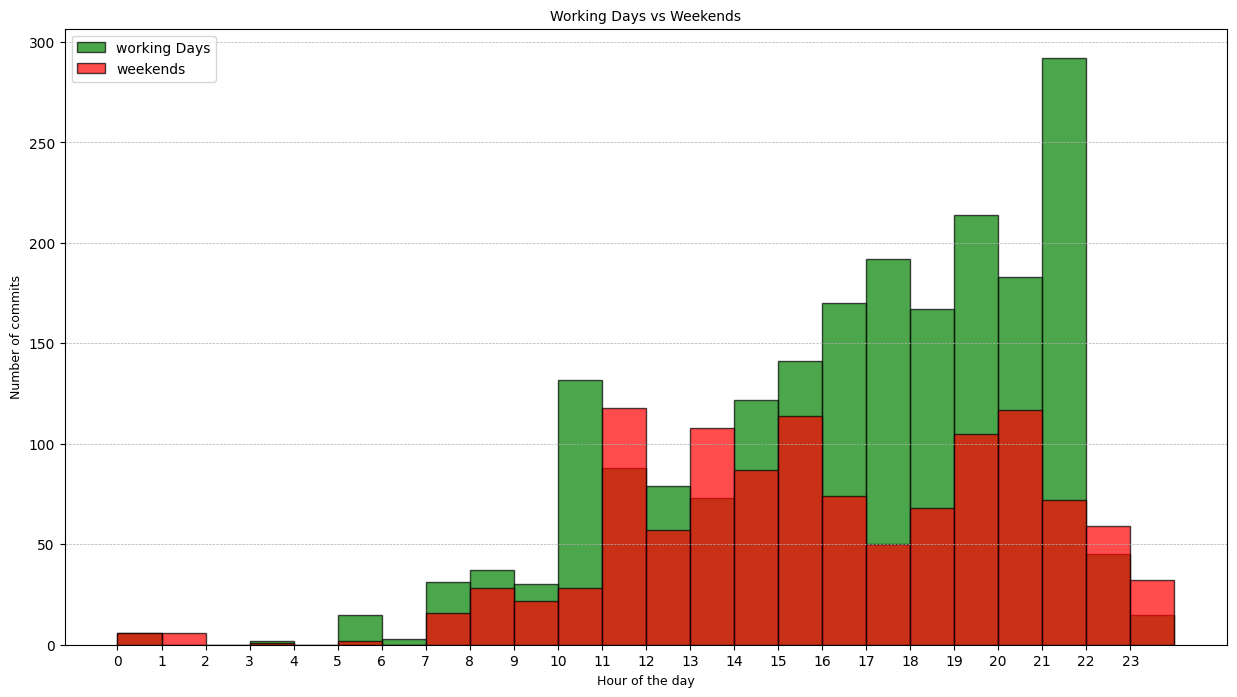

In [37]:
# Построение гистограммы
plt.figure(figsize=(15, 8))
plt.hist(
    working_hours, bins=24, range=(0, 24), alpha=0.7, label="working Days",
    color="green", edgecolor='black'
)
plt.hist(
    weekend_hours, bins=24, range=(0, 24), alpha=0.7, label="weekends",
    color="red", edgecolor='black'
)

plt.title("Working Days vs Weekends", fontsize=10)
plt.xlabel("Hour of the day", fontsize=9)
plt.ylabel("Number of commits", fontsize=9)
plt.xticks(range(0, 24))
plt.legend()
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()

In [38]:
# Подсчёт по часам
work_counts = pd.Series(working_hours).value_counts().sort_index()
weekend_counts = pd.Series(weekend_hours).value_counts().sort_index()

# Объединение и нахождение разницы
comparison = pd.DataFrame({
    "weekend": weekend_counts,
    "working": work_counts
}).fillna(0).astype(int)

# Разница
comparison["diff"] = comparison["weekend"] - comparison["working"]

# Топ-4 часа, когда на выходных было больше коммитов
top4 = comparison[comparison["diff"] > 0].sort_values("diff", ascending=False).head(4)
print(top4)


    weekend  working  diff
13      108       73    35
11      118       88    30
23       32       15    17
22       59       45    14


In [39]:
conn.close()

## Вопрос:
Бывают ли часы, когда общее количество коммитов в выходные дни было выше, чем в будние дни?

Топ-4 таких часов: **11, 13, 22, 23**.